In [1]:
from pathlib import Path
import drms
from datetime import datetime
from sunpy.map import Map
import matplotlib.pyplot as plt
import numpy as np
import torch
from magplot.base import create_mesh, mag_plotter

import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

from streamtracer import StreamTracer, VectorGrid

import argparse
from neuralop.models import UNO
from skimage.transform import resize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.unpack import get_b

from rtmag.test.eval import evaluate

In [2]:
b_true = np.load('/mnt/f/isee_dataset/11158/label/label_11158_20110215_000000.npz')['label']
b_true = b_true[:, :-1, :-1, :-1]
b_true = b_true.transpose(1, 2, 3, 0)
b_true.shape

(512, 256, 256, 3)

In [3]:
b_pot = np.load('/mnt/f/isee_dataset/11158/label/label_11158_20110215_000000.npz')['pot']
b_pot = b_pot[:, :-1, :-1, :-1]
b_pot = b_pot.transpose(1, 2, 3, 0)
b_pot.shape

(512, 256, 256, 3)

In [4]:
# (batch, 1, ny, nx, 3)
model_input = torch.from_numpy(b_true[:, :, 0, :].transpose(1, 0, 2)[None, None, ...])
model_input.shape

torch.Size([1, 1, 256, 512, 3])

In [5]:
meta_path = Path("/home/usr/workspace/base/pino_CC_Hnorm_Unit_2")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

b_norm = torch.max(torch.abs(model_input)).item()
model_input = model_input / b_norm
model_input = model_input.to(device)

# [batch,   1, 256, 512, 3] -> [batch, 256, 256, 512, 3]
model_output = model(model_input)
# [batch, 256, 256, 512, 3] -> [512, 256, 256, 3]
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [20]:
b_nf2 = get_b("/home/usr/workspace/paper/train/nf2/base_11158_series/20110215_000000.nf2", device)

100%|██████████| 3389/3389 [00:05<00:00, 661.47it/s]


In [21]:
b_nf2 = b_nf2[:-1, :-1, :-1, :]
b_nf2.shape

(512, 256, 256, 3)

In [8]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = 512
Ly = 256
numbers = 30
xyranges = [
    [0.33, 0.40, 0.38, 0.50],
    [0.50, 0.60, 0.50, 0.70],
    [0.65, 0.70, 0.70, 0.80],
]
grid_spacing = [1, 1, 1]

grid_true = VectorGrid(b_true, grid_spacing)
grid = VectorGrid(b, grid_spacing)
grid_nf2 = VectorGrid(b_nf2, grid_spacing)
grid_pot = VectorGrid(b_pot, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []
tracer_xs_nf2 = []
tracer_xs_pot = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)
    tracer.trace(seeds, grid_true)
    tracer_xs_true.append(tracer.xs)
    tracer.trace(seeds, grid_nf2)
    tracer_xs_nf2.append(tracer.xs)
    tracer.trace(seeds, grid_pot)
    tracer_xs_pot.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]
tracer_xs_true = [item for sublist in tracer_xs_true for item in sublist]
tracer_xs_nf2 = [item for sublist in tracer_xs_nf2 for item in sublist]
tracer_xs_pot = [item for sublist in tracer_xs_pot for item in sublist]

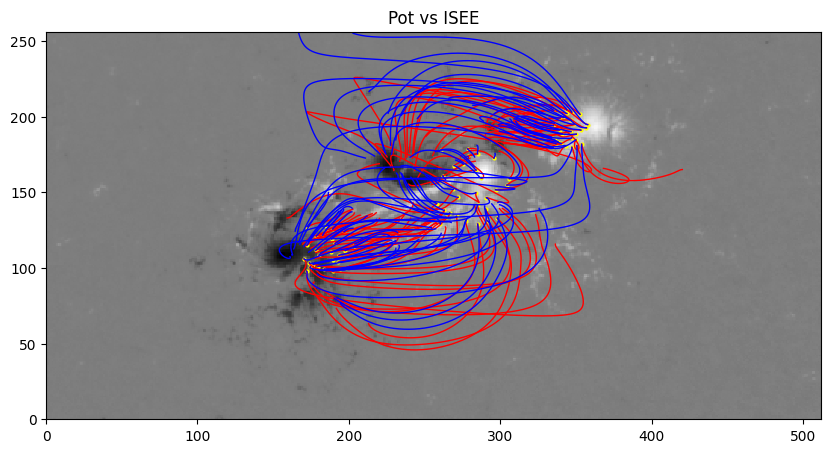

In [9]:
seedcolor = 'yellow'
seedsize = 2
linecolor_true = 'red'
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b_true[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor_true, linewidth=linesize)
for xl in tracer_xs_pot:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("Pot vs ISEE")
plt.show()

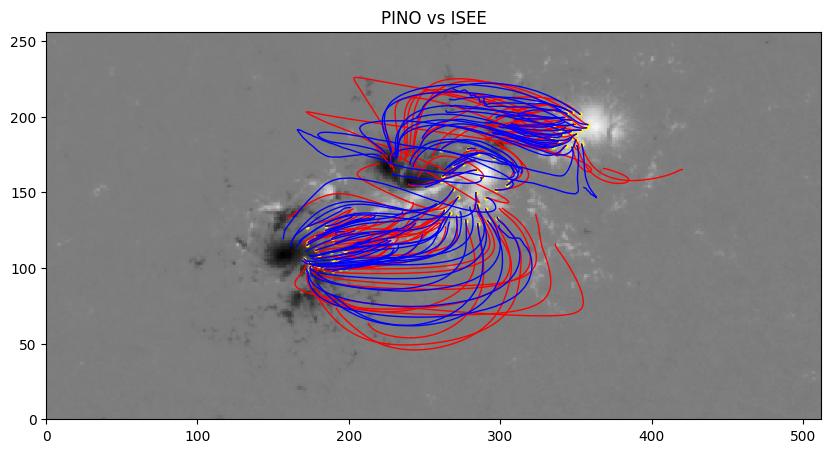

In [10]:
seedcolor = 'yellow'
seedsize = 2
linecolor_true = 'red'
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b_true[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor_true, linewidth=linesize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("PINO vs ISEE")
plt.show()

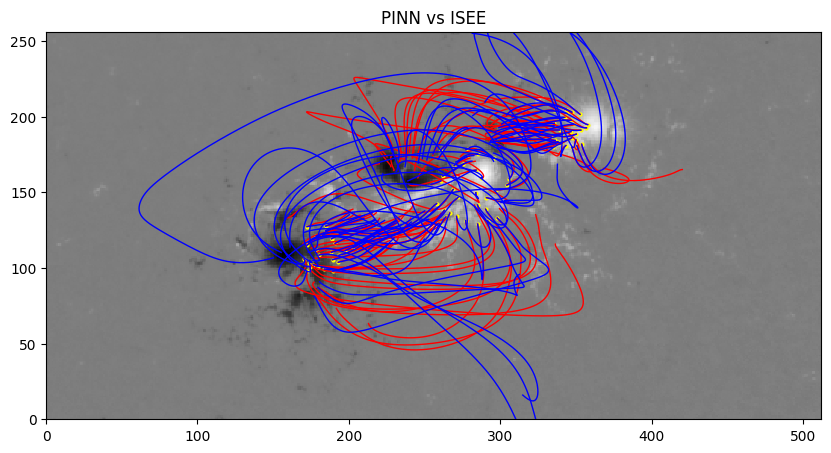

In [11]:
seedcolor = 'yellow'
seedsize = 2
linecolor_true = 'red'
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b_true[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor_true, linewidth=linesize)
for xl in tracer_xs_nf2:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("PINN vs ISEE")
plt.show()

In [12]:
harpnum = 377
download_dir = Path("download") / str(harpnum)
hmi_Br = Map(str(download_dir / "hmi" / "hmi.sharp_cea_720s.377.20110215_000000_TAI.Br.fits"))

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


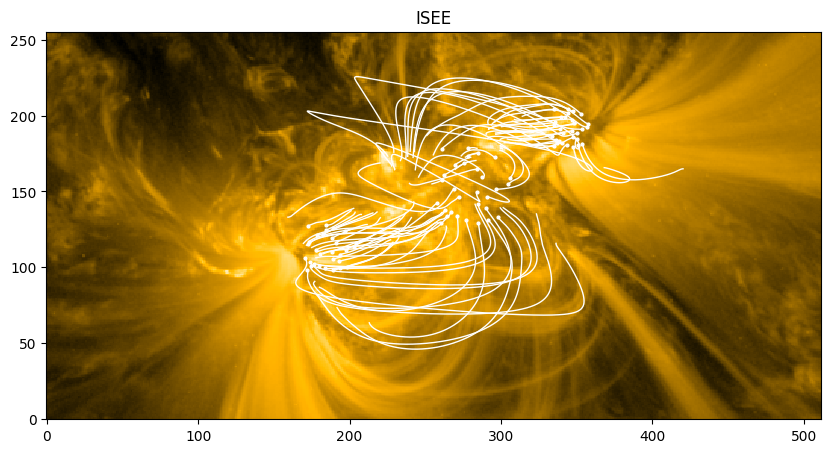

In [13]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171 = aia_171.reproject_to(hmi_Br.wcs)
aia_171_data = resize(aia_171.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_171_data, **aia_171.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("ISEE")
plt.show()

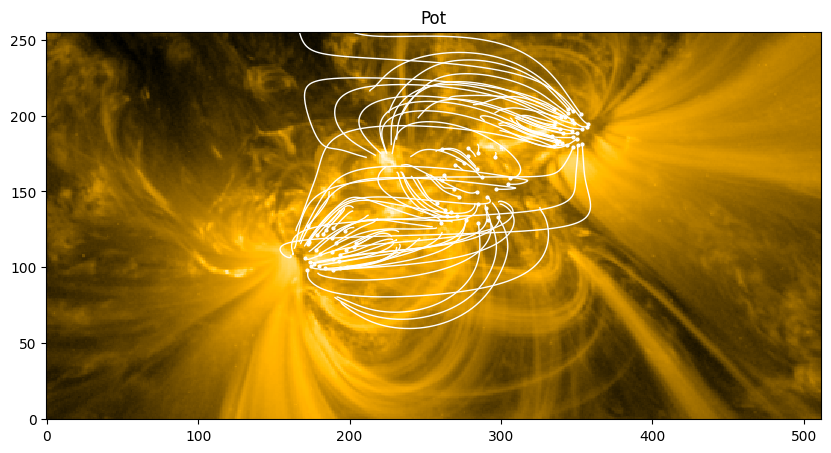

In [14]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171 = aia_171.reproject_to(hmi_Br.wcs)
aia_171_data = resize(aia_171.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_171_data, **aia_171.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_pot:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("Pot")
plt.show()

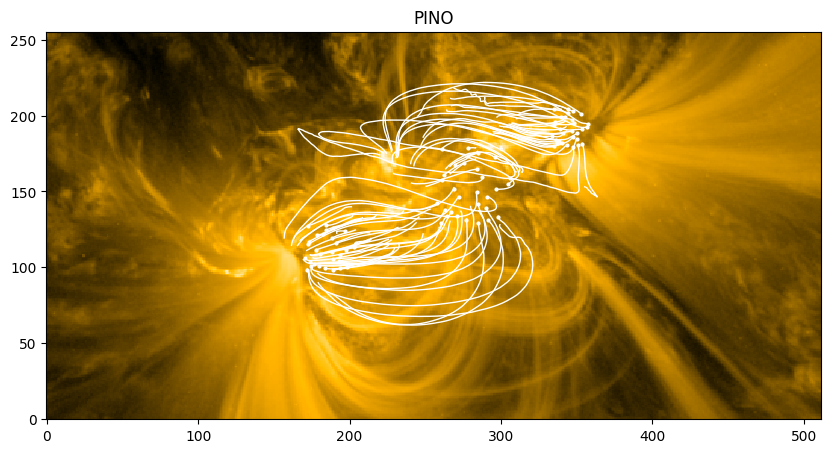

In [15]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171 = aia_171.reproject_to(hmi_Br.wcs)
aia_171_data = resize(aia_171.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_171_data, **aia_171.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("PINO")
plt.show()

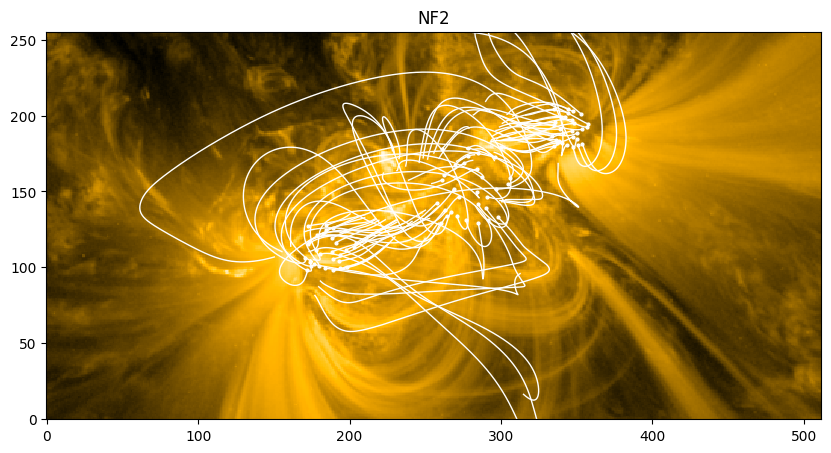

In [16]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171 = aia_171.reproject_to(hmi_Br.wcs)
aia_171_data = resize(aia_171.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_171_data, **aia_171.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_nf2:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("NF2")
plt.show()

In [17]:
evaluate(b, b_true)

C_vec     : 0.9671
C_cs      : 0.9686
E_n'      : 0.7599
E_m'      : 0.7401
eps       : 0.9091
CW_sin    : 0.8054
L_f       : 77.5206
L_d       : 40.3858
l2_err    : 0.2561


{'C_vec': 0.9670980046411076,
 'C_cs': 0.9686239013175663,
 "E_n'": 0.7599250402868595,
 "E_m'": 0.7401165099394147,
 'eps': 0.9090806705898187,
 'CW_sin': 0.805416529805541,
 'L_f': 77.52057716350228,
 'L_d': 40.3857944204856,
 'l2_err': 0.2560530851732926}

In [22]:
evaluate(b_nf2, b_true)

C_vec     : 0.9245
C_cs      : 0.4477
E_n'      : 0.3307
E_m'      : -0.1457
eps       : 0.9087
CW_sin    : 0.1548
L_f       : 0.1031
L_d       : 0.0385
l2_err    : 0.3815


{'C_vec': 0.9244913,
 'C_cs': 0.44773027300834656,
 "E_n'": 0.330743670463562,
 "E_m'": -0.14572811126708984,
 'eps': 0.9087009,
 'CW_sin': 0.15476869,
 'L_f': 0.10305889,
 'L_d': 0.03847606,
 'l2_err': 0.38150766}